# Data analysis before modelling


# Module import 

In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import recall_score, precision_recall_curve, average_precision_score

# Util function

In [2]:
def remove_skewed_columns(df):
# this function was used to remove the column that has only one value
    for column in df:
        if len(df[column].unique()) == 1:
            df.drop(columns=column, inplace=True)
    return df

# Load data and inspection
- flag: woe_run. If woe_run = True, credit_risk_data after woe trasformation will be loaded ("../woe_transformation/dataset_test_woed.csv"). If woe_run = False, raw credit_risk_data will be loaded ("../credit_risk_data.csv").
- woe transformed data was stored in "../woe_transformation/woe_transformed_credit_dataset.csv" 

In [3]:
woe_run = True

In [4]:
# load the file
if woe_run: 
    df = pd.read_csv("../woe_transformation/woe_transformed_credit_dataset.csv", index_col=["ID"])
    df.drop( "Unnamed: 0", axis=1, inplace=True)
    df.rename(columns={"target": "default payment next month"}, inplace=True)
else:
    df = pd.read_csv("../credit_risk_data.csv", skiprows=1, index_col="ID")

scale_pos_weight = round(sum(abs(df["default payment next month"] - 1))/sum(df["default payment next month"]))
df.head()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,0.692865,-0.079777,0.091416,0.076822,0.041466,2.065423,1.473415,-0.430029,-0.407307,-0.147246,...,0.061971,0.111703,0.056681,0.677342,0.012750,0.521223,0.463320,0.382161,0.361833,1
2,0.103760,-0.079777,0.091416,-0.072942,0.041466,-0.342752,1.473415,-0.295297,-0.235542,-0.200910,...,-0.341374,-0.383466,-0.434588,0.677342,0.053114,0.098836,0.046470,0.382161,0.007203,1
3,0.103760,-0.079777,0.091416,-0.072942,-0.161146,-0.659061,-0.406083,-0.295297,-0.235542,-0.200910,...,-0.023247,0.119063,0.121763,0.120994,0.174191,0.098836,0.046470,0.026641,-0.370422,0
4,0.273008,-0.079777,0.091416,0.076822,0.052545,-0.659061,-0.406083,-0.295297,-0.235542,-0.200910,...,0.178366,0.202243,0.226296,0.043100,-0.183815,-0.083967,0.046470,0.026641,-0.094260,0
5,0.273008,0.115154,0.091416,0.076822,0.052545,-0.342752,-0.406083,-0.430029,-0.235542,-0.200910,...,0.243437,0.247299,0.301036,0.043100,-1.125815,-0.541741,-0.449736,0.181627,0.236430,0


# Data preprocessing

## Skewed columns
- remove the columns with the same value, whichwill not contribute to the classification

In [32]:
df = remove_skewed_columns(df)

## Zero data
- if woe_run = True, woe_transformation will be used. No code in this block will be executed
- if woe_run = False, you need to choose 
    - T1: treat all the unreasonable data as missing data and labeled 0.
    - T2: treat all the unreasonable data as most frequent value in this column
    - T3: treat all the unreasonable data as missing data and labeled 0, and for pay status, set 0 for all negatives and 1 for positives
- if woe_run = False, one-hot encoding will be implemented on columns "SEX", "EDUCATION", "MARRIAGE"

In [33]:
Test = "T2"

In [34]:
if not woe_run:
    if Test == "T1":
        df["EDUCATION"][df["EDUCATION"] == 5] = 0
        df["EDUCATION"][df["EDUCATION"] == 6] = 0
    elif Test == "T2":
        count = 0
        for i in range(5):
            if sum(df["EDUCATION"]==i) > count:
                count = sum(df["EDUCATION"]==i)
                max = i
        df["EDUCATION"][df["EDUCATION"] == 5] = max
        df["EDUCATION"][df["EDUCATION"] == 6] = max

    elif Test == "T3":
        df["EDUCATION"][df["EDUCATION"] == 5] = 0
        df["EDUCATION"][df["EDUCATION"] == 6] = 0
        for i in [0, 2, 3, 4, 5, 6]:
            df["PAY_" + str(i)][df["PAY_" + str(i)] < 0] = 0
            df["PAY_" + str(i)][df["PAY_" + str(i)] > 0] = 1
# one-hot encoding, convert "SEX", "EDUCATION", "MARRIAGE" to category data using one-hot encode
    df_encoded = pd.get_dummies(df,columns=["SEX", "EDUCATION", "MARRIAGE"])
else:
    df_encoded = df
# len(df["PAY_" + str(0)][df["PAY_" + str(i)] < 0])
    

# Feature selection
compare the model behaviours with different features using AUC_pr. One feature was removed in each iteration. If auc_pr value is enhanced, the feature will be removed. Otherwise, the feature will be kept.

## Train and test data split

In [35]:
X = df_encoded.drop("default payment next month", axis=1).copy()
y = df_encoded["default payment next month"].copy()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 8, stratify = y)

## Baseline model
- all features included

In [36]:
# fit the model with all features
trial_xgb = xgb.XGBClassifier(n_estimators= 40,objective="binary:logistic", verbosity = 0, scale_pos_weight = scale_pos_weight, use_label_encoder=False, random_state = 10)
trial_xgb.fit(X_train, y_train, verbose=True , early_stopping_rounds = 10, eval_metric="aucpr",eval_set=[(X_test,y_test)])
trial_auc = np.array(trial_xgb.evals_result()['validation_0']['aucpr']).max()
# plot_confusion_matrix(trial_xgb, X_test,y_test, display_labels=["Default not on the loan", "Default on the loan"]) 
# trial_xgb.evals_result()


[0]	validation_0-aucpr:0.51990
[1]	validation_0-aucpr:0.52328
[2]	validation_0-aucpr:0.52945
[3]	validation_0-aucpr:0.52703
[4]	validation_0-aucpr:0.52478
[5]	validation_0-aucpr:0.52834
[6]	validation_0-aucpr:0.52933
[7]	validation_0-aucpr:0.53030
[8]	validation_0-aucpr:0.52887
[9]	validation_0-aucpr:0.52911
[10]	validation_0-aucpr:0.52868
[11]	validation_0-aucpr:0.52617
[12]	validation_0-aucpr:0.52629
[13]	validation_0-aucpr:0.52803
[14]	validation_0-aucpr:0.52693
[15]	validation_0-aucpr:0.52766
[16]	validation_0-aucpr:0.52752


# Feature iteration
- the removed columns will be recorded in removed_cols

In [26]:
# use auc under pr to calculate the feature, 
X_copy = X.copy()
removed_cols = []
for col in X:
    X_train, X_test, y_train, y_test = train_test_split(X_copy.drop(col, axis=1).copy(),y, test_size=0.2, random_state = 8, stratify = y)
    trial_xgb.fit(X_train, y_train, verbose = False, eval_metric="aucpr",eval_set=[(X_test,y_test)])
    # auc under pr
    trial_auc2 = np.array(trial_xgb.evals_result()['validation_0']['aucpr']).max()
    y_pred = trial_xgb.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    recall_val2 = cm[1,1] / (cm[1,0]+cm[1,1])
    if abs(trial_auc2 - trial_auc) > 0.05:
        removed_cols.append({"col": col, "aucpr": trial_auc2})
        X_copy.drop(col, axis=1, inplace=True)
removed_cols

[]

In [63]:
# calculate recall value
# y_pred = trial_xgb.predict(X_test)
# cm = confusion_matrix(y_test, y_pred)
# recall_val = cm[1,1] / (cm[1,0]+cm[1,1])
# recall_val

In [27]:
# plot_confusion_matrix(trial_xgb, X_test, y_test)

# Feature selection results
- no feature should be removed in the situation where T1, T2, T3, and woe transformed were used.
- T1 and woe transformed data gave the best performance in the feature selection process

# Save the features
- without woe: T1 processed saved data -> "./processed_data_T1.p"

- with woe: woe processed saved data -> "./woe_data_model/processed_data_woe.p"

In [66]:

pickle.dump( {"X": X_copy, "y": y, "auc_pr": trial_xgb.evals_result()['validation_0']['aucpr']}, open( "./woe_data_model/processed_data_woe.p", "wb" ) )


# Plot data
this part can be changed for specific purpose

In [128]:
# T1_features = pickle.load(open( "selected_feature_T1.p", "rb" ))
# T1_aucpr = T1_features["auc_pr"]

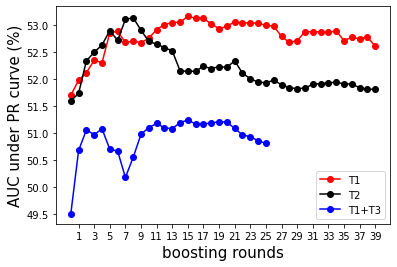

In [136]:
# f1 = plt.figure()
# t1t3, = plt.plot([x for x in range(len(trial_xgb.evals_result()['validation_0']['aucpr']))], 
#          np.array(trial_xgb.evals_result()['validation_0']['aucpr'])*100, "bo-")

# # t1, = plt.plot([x for x in range(len(T1_aucpr))], 
# #          np.array(T1_aucpr)*100, "ro-")
# # t2, = plt.plot([x for x in range(len(T2_aucpr))], 
# #          np.array(T2_aucpr)*100, "ko-")

# plt.xticks([x for x in range(len(T1_aucpr)) if x % 2 != 0], [x for x in range(len(T1_aucpr)) if x % 2 != 0])
# plt.xlabel("boosting rounds", fontsize=15)
# plt.ylabel("AUC under PR curve (%)", fontsize=15)
# plt.legend([t1, t2, t1t3], ["T1", "T2", "T1+T3"])
# f1.savefig('test.jpg', format='jpg', dpi=1200)